***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


***

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from glob import glob

import category_encoders as ce
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torchinfo
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from adabelief_pytorch import AdaBelief
import pytorch_axe as pax
import time
from tqdm import tqdm

import sys
sys.path.append("../utils")
from features import Featurador
from inventory import IDP

pd.set_option('display.max_columns', None)

In [5]:
SEED = 19
SUB_NBR = str(max([int(fn.split("/")[-1].split(".")[0][3:]) for fn in glob(f"{subs_path}/*")]))
print(SUB_NBR)

15


In [6]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
def compute_rps(preds, targets):
    return np.mean(np.sum((targets - preds)**2, axis=1))
    
set_seed(SEED)

In [7]:
# device in which the model will be trained
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

***
## data preparation

In [8]:
limit_date = "2021-03-01"

In [9]:
oof = pd.read_csv(f"{results_path}/oof_preds_lgbm-m1.csv")
oof_skus = oof.sku.unique()
len(oof_skus)

421636

In [10]:
fit_stats = pd.read_csv(f"{results_path}/train_errors_lgbm-m1-stg1.csv")
fit_stats.drop(["q_mean","site_id"], axis=1, inplace=True)

for col in fit_stats.columns:
    fit_stats[col] = fit_stats[col].fillna(fit_stats[col].median())
    
len(fit_stats)

421636

In [11]:
dataset = (
    pd.read_parquet(f"{input_path}/train.parquet")
    .query("sku in @oof_skus")
    .query("date <= @limit_date")
    .sort_values(["sku","date"])
    .reset_index(drop=True)
)
dataset.sku.nunique()

421636

In [12]:
raw = (
    pd.read_parquet(
        f"{input_path}/train_data.parquet", 
        columns=["sku", "date", "sold_quantity", "minutes_active"]
    )
    .query("sku in @oof_skus")
    .sort_values(["sku","date"])
    .reset_index(drop=True)
)
metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
raw = pd.merge(raw, metadata, how="inner", on="sku")
raw.sku.nunique()

421636

In [13]:
valid = (
    pd.read_csv(f"{input_path}/validation_realstock.csv")
    .query("sku in @oof_skus")
    .reset_index(drop=True)
)
valid.sku.nunique()

421636

### Build features at sku level 

In [14]:
feat = Featurador(raw)
feat.fit(left_limit="2021-02-01", right_limit="2021-03-01")
dataset = feat.transform(dataset)

In [15]:
dataset["was_active"] = dataset.eval("minutes_active > 0")
dataset["had_sales"] = dataset.eval("sold_quantity > 0")

dataset["tr_points"] = dataset.groupby("sku")["date"].transform("count")
dataset["completeness"] = dataset.tr_points / (dataset.date.nunique())

dataset["minutes_rate1"] = dataset.groupby("sku")["minutes_active"].transform("sum") / (dataset.tr_points*1440)
dataset["minutes_rate2"] = dataset.groupby("sku")["minutes_active"].transform("sum") / (dataset.date.nunique()*1440)

dataset["activity_rate1"] = dataset.groupby("sku")["was_active"].transform("sum") / (dataset.tr_points)
dataset["activity_rate2"] = dataset.groupby("sku")["was_active"].transform("sum") / (dataset.date.nunique())

dataset["sales_rate1"] = dataset.groupby("sku")["had_sales"].transform("sum") / (dataset.tr_points)
dataset["sales_rate2"] = dataset.groupby("sku")["had_sales"].transform("sum") / (dataset.date.nunique())

dataset["q_mean_raw"] = dataset.groupby("sku")["sold_quantity"].transform("mean")
dataset["q_std_raw"] = dataset.groupby("sku")["sold_quantity"].transform("std")

In [16]:
# imputation of nan values
idx = dataset[dataset["q_mean"].isna()].index
dataset.loc[idx, "q_mean"] = dataset.q_mean.median()

idx = dataset[dataset["q_std"].isna()].index
dataset.loc[idx, "q_std"] = dataset.q_std.median()

idx = dataset[dataset["q_mean_raw"].isna()].index
dataset.loc[idx, "q_mean_raw"] = dataset.q_mean_raw.median()

idx = dataset[dataset["q_std_raw"].isna()].index
dataset.loc[idx, "q_std_raw"] = dataset.q_std_raw.median()

In [17]:
dataset["std_days"] = dataset.eval("q_std / q_mean")
idx = dataset[dataset["std_days"].isna()].index
dataset.loc[idx, "std_days"] = dataset.std_days.median()
print(len(idx))

dataset["std_days_raw"] = dataset.eval("q_std_raw / q_mean_raw")
idx = dataset[dataset["std_days_raw"].isna()].index
dataset.loc[idx, "std_days_raw"] = dataset.std_days_raw.median()
print(len(idx))

0
0


In [18]:
dataset = dataset.drop_duplicates(subset=["sku"], ignore_index=True)
display(dataset)
gc.collect()

,date,sku,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,available,item_domain_id,item_id,site_id,product_id,product_family_id,q_mean,q_std,was_active,had_sales,tr_points,completeness,minutes_rate1,minutes_rate2,activity_rate1,activity_rate2,sales_rate1,sales_rate2,q_mean_raw,q_std_raw,std_days,std_days_raw
0,2021-02-01,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None,0.851802,0.850460,False,False,29,1.0,0.270289,0.270289,0.275862,0.275862,0.137931,0.137931,0.241379,0.635563,0.998424,2.633049
1,2021-02-01,3,0,399.000000,MEX,premium,fulfillment,free_shipping,1440.0,1,MLM-RINGS,298603,MLM,None,None,0.342646,0.225240,True,False,29,1.0,0.702826,0.702826,0.724138,0.724138,0.241379,0.241379,0.241379,0.435494,0.657354,1.804190
2,2021-02-01,5,0,558.690002,MEX,premium,fulfillment,free_shipping,0.0,1,MLM-RADIO_FREQUENCY_MACHINES,124265,MLM,None,None,0.327202,0.220141,False,False,29,1.0,0.105387,0.105387,0.137931,0.137931,0.034483,0.034483,0.034483,0.185695,0.672798,5.385165
3,2021-02-01,6,0,490.000000,MEX,classic,fulfillment,free_shipping,1440.0,1,MLM-TABLET_CASES,345180,MLM,None,None,0.655172,0.708680,True,False,29,1.0,1.000000,1.000000,1.000000,1.000000,0.448276,0.448276,0.655172,0.856732,1.081670,1.307644
4,2021-02-01,7,0,98.900002,REA,classic,fulfillment,paid_shipping,0.0,1,MLB-BEERS,478738,MLB,None,None,2.010820,8.267918,False,False,29,1.0,0.465889,0.465889,0.517241,0.517241,0.275862,0.275862,0.965517,2.243765,4.111714,2.323900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421631,2021-02-01,660909,1,245.000000,ARG,classic,fulfillment,paid_shipping,1440.0,1,MLA-PENCILS,430327,MLA,None,None,0.482759,0.663496,True,True,29,1.0,1.000000,1.000000,1.000000,1.000000,0.379310,0.379310,0.482759,0.828971,1.374384,1.717153
421632,2021-02-01,660911,0,14.310000,REA,classic,fulfillment,paid_shipping,1440.0,1,MLB-CELLPHONE_PARTS,320792,MLB,None,None,0.258822,0.269248,True,False,29,1.0,0.890853,0.890853,0.931034,0.931034,0.206897,0.206897,0.241379,0.510964,1.040283,2.116849
421633,2021-02-01,660912,0,99.000000,MEX,classic,fulfillment,paid_shipping,1440.0,1,MLM-AUTOMOTIVE_EMBLEMS,90441,MLM,None,None,0.282363,0.741740,True,False,29,1.0,0.767555,0.767555,0.793103,0.793103,0.137931,0.137931,0.241379,0.786274,2.626903,3.257420
421634,2021-02-01,660913,0,149.899994,REA,premium,drop_off,free_shipping,1440.0,1,MLB-SOFA_AND_FUTON_COVERS,202580,MLB,None,None,0.034491,0.033302,True,False,29,1.0,0.999751,0.999751,1.000000,1.000000,0.034483,0.034483,0.034483,0.185695,0.965509,5.385165


3

In [19]:
# inventory days predictions (oof) from the model
predictor = IDP()
predictor.fit(oof)

100%|██████████| 421636/421636 [01:47<00:00, 3931.12it/s]


In [20]:
preds1 = list()
preds2 = list()
for i,row in tqdm(valid.iterrows()):
    idp,idp_clip = predictor.predict(int(row.sku), int(row.target_stock))
    preds1.append(idp)
    preds2.append(idp_clip)
    
id_preds = pd.DataFrame({
    "sku":valid.sku.values, 
    "idp":preds1, 
    "idp_clip":preds2}
)
id_preds["no_stockout"] = id_preds.eval("idp > 30").astype(int)
id_preds = pd.merge(id_preds, valid, how="inner", on="sku")
id_preds

421636it [01:09, 6034.99it/s]


,sku,idp,idp_clip,no_stockout,target_stock,inventory_days
0,1,26.364512,26.364512,0,13,27.0
1,3,27.954181,27.954181,0,3,inf
2,5,inf,30.000000,1,12,29.0
3,6,15.099747,15.099747,0,3,17.0
4,7,-inf,1.000000,0,1,2.0
...,...,...,...,...,...,...
421631,660909,3.774088,3.774088,0,2,4.0
421632,660911,13.571797,13.571797,0,4,14.0
421633,660912,5.629803,5.629803,0,2,19.0
421634,660913,inf,30.000000,1,13,inf


In [21]:
print("mean ae:", id_preds.query("inventory_days <= 31").eval("abs(inventory_days - idp_clip)").mean())
print("median ae", id_preds.query("inventory_days <= 31").eval("abs(inventory_days - idp_clip)").median())

mean ae: 5.974666498404377
median ae 3.878696762659697


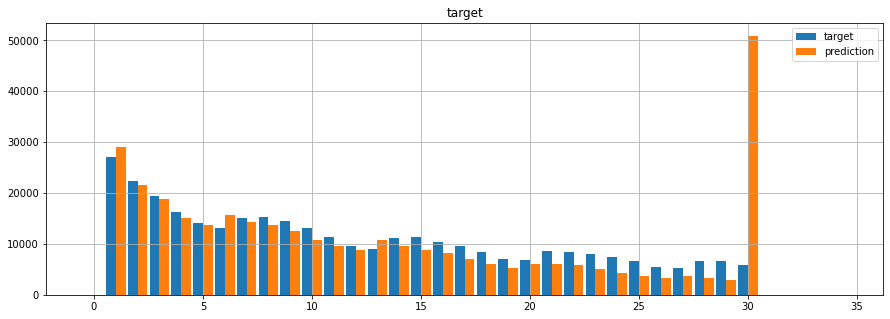

In [22]:
plt.figure(figsize=(15,5))
plt.hist(
    [id_preds.query("inventory_days <= 31").inventory_days.values, 
     id_preds.query("inventory_days <= 31").idp_clip.values], 
    bins=np.arange(0,36), 
    rwidth=0.9, 
    align="left",
    label=["target","prediction"]
)
plt.title("target")
plt.legend(loc="best")
plt.grid()
plt.show()

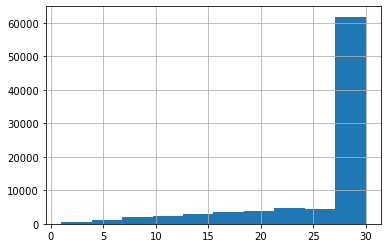

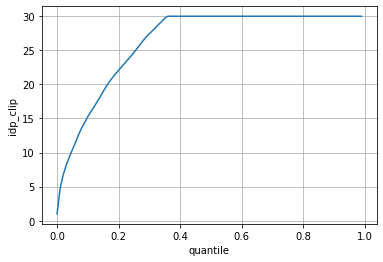

In [23]:
id_preds.query("inventory_days > 30").idp_clip.hist()
plt.show()

id_preds.query("inventory_days > 30").idp_clip.quantile(np.arange(0,1,0.01)).plot()
plt.xlabel("quantile")
plt.ylabel("idp_clip")
plt.grid()
plt.show()

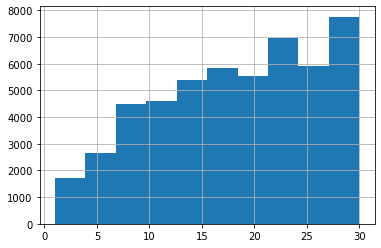

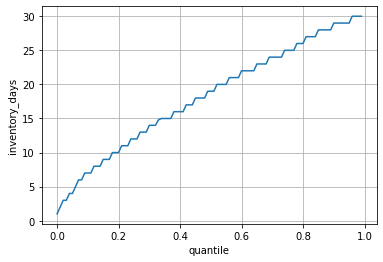

In [24]:
id_preds.query("idp_clip >= 30 & inventory_days <= 30").inventory_days.hist()
plt.show()

id_preds.query("idp_clip >= 30 & inventory_days <= 30").inventory_days.quantile(np.arange(0,1,0.01)).plot()
plt.xlabel("quantile")
plt.ylabel("inventory_days")
plt.grid()
plt.show()

In [25]:
idx = id_preds.query("inventory_days > 31").index
id_preds.loc[idx, "inventory_days"] = 35

idx = id_preds.query("idp > 31").index
id_preds.loc[idx, "idp"] = 35
idx = id_preds.query("idp < 1").index
id_preds.loc[idx, "idp"] = 1

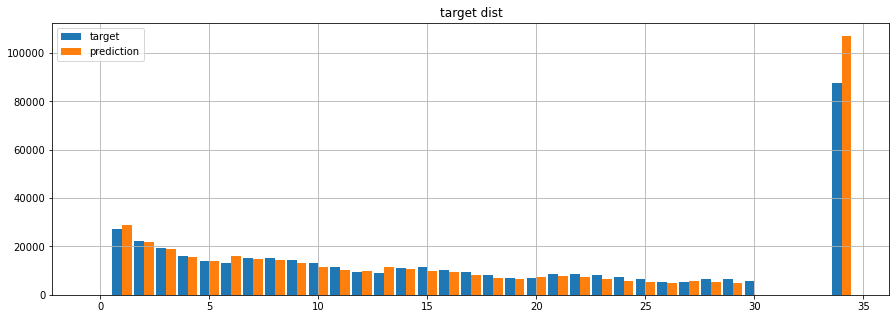

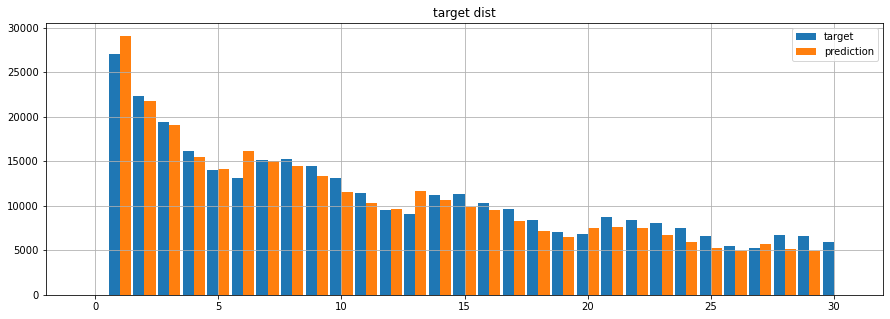

In [26]:
plt.figure(figsize=(15,5))
plt.hist([id_preds.inventory_days.values, id_preds.idp.values], bins=np.arange(0,36), rwidth=0.9, align="left", label=["target","prediction"])
plt.grid()
plt.title("target dist")
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(15,5))
plt.hist([id_preds.inventory_days.values, id_preds.idp.values], bins=np.arange(0,32), rwidth=0.9, align="left", label=["target","prediction"])
plt.grid()
plt.title("target dist")
plt.legend(loc="best")
plt.show()

In [27]:
dataset = (
    dataset
    .merge(id_preds, how="inner", on="sku")
    .merge(fit_stats, how="inner", on="sku")
)
dataset["idp_naive1"] = dataset.eval("target_stock / q_mean")
dataset["idp_naive2"] = dataset.eval("target_stock / q_mean_raw")
dataset.isna().sum(axis=0)

date                           0
sku                            0
sold_quantity                  0
current_price                  0
currency                       0
listing_type                   0
shipping_logistic_type         0
shipping_payment               0
minutes_active                 0
available                      0
item_domain_id                 0
item_id                        0
site_id                        0
product_id                406918
product_family_id         373963
q_mean                         0
q_std                          0
was_active                     0
had_sales                      0
tr_points                      0
completeness                   0
minutes_rate1                  0
minutes_rate2                  0
activity_rate1                 0
activity_rate2                 0
sales_rate1                    0
sales_rate2                    0
q_mean_raw                     0
q_std_raw                      0
std_days                       0
std_days_r

In [28]:
input_cols = [
    # sold_quantity stats
    "q_mean",
    "q_mean_raw",
    "q_std",
    "q_std_raw",
    "std_days",
    "std_days_raw",
    
    # train fit stats
    "rmsse",
    "rmse_norm",
    "mean_ae_norm",
    "median_ae_norm",
    "residual_std_norm",
    "residual_mad_norm",
    
    # activity on history
    "completeness",
    "minutes_rate1",
    "minutes_rate2",
    "activity_rate1",
    "activity_rate2",
    "sales_rate1",
    "sales_rate2",
    
    # ID predictions
    "target_stock",
    "idp_clip",
    "no_stockout",
    "idp_naive1",
    "idp_naive2",
    
    # others
    "site_id",
]
categ_cols = [
    "site_id",
]

print("# feats:", len(input_cols))

# feats: 25


In [29]:
encoder = ce.OneHotEncoder()
transformed = encoder.fit_transform(dataset[categ_cols])
dataset[transformed.columns] = transformed.values
for col in categ_cols:
    input_cols.remove(col)
input_cols.extend(transformed.columns.tolist())

/Users/mavillan/miniconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [30]:
assert dataset[input_cols].isna().sum(axis=0).sum() == 0

In [31]:
# for now, we only consider skus that sold their stock
idx = dataset.query("inventory_days > 30").index
dataset = dataset.drop(idx).reset_index(drop=True)
dataset["inventory_days"] = dataset["inventory_days"].astype(int)

print(f"Number of rows removed: {len(idx)}")

Number of rows removed: 87409


In [33]:
# generate the target for each sku (cumulative distribution)
y_true = dataset.inventory_days.values.copy()
y_true_one_hot = np.zeros((len(y_true),30), dtype=np.float64)
y_true_one_hot[range(len(y_true)), y_true-1] = 1
y_true = np.cumsum(y_true_one_hot, axis=1)
targets = pd.DataFrame(y_true, index=dataset.sku.values)
targets.index.rename("sku", inplace=True)
targets = targets.reset_index()

***
## model definition

In [34]:
@torch.jit.script
def rps_loss(preds, targets):
    return torch.mean(torch.sum((targets - preds)**2, dim=1))

class DNN(nn.Module):

    def __init__(self, input_dim, output_dim, nn_depth, nn_width, dropout, momentum):
        super().__init__()

        self.bn_in = nn.BatchNorm1d(input_dim, momentum=momentum)
        self.dp_in = nn.Dropout(dropout)        
        self.ln_in = nn.utils.weight_norm(nn.Linear(input_dim, nn_width, bias=False))

        self.bnorms = nn.ModuleList([
            nn.BatchNorm1d(nn_width, momentum=momentum) 
            for i in range(nn_depth-1)
        ])
        self.dropouts = nn.ModuleList([
            nn.Dropout(dropout) 
            for i in range(nn_depth-1)
        ])
        self.linears = nn.ModuleList([
            nn.utils.weight_norm(nn.Linear(nn_width, nn_width, bias=False))
            for i in range(nn_depth-1)
        ])
        
        self.bn_out = nn.BatchNorm1d(nn_width, momentum=momentum)
        self.dp_out = nn.Dropout(dropout/2)
        self.ln_out = nn.utils.weight_norm(nn.Linear(nn_width, output_dim, bias=False))

    def forward(self, x):
        x = self.bn_in(x)
        x = self.dp_in(x)
        x = nn.functional.relu(self.ln_in(x))

        for bn_layer,dp_layer,ln_layer in zip(self.bnorms,self.dropouts,self.linears):
            x = bn_layer(x)
            x = dp_layer(x)
            x = ln_layer(x)
            x = nn.functional.relu(x)
            
        x = self.bn_out(x)
        x = self.dp_out(x)
        x = self.ln_out(x)
        x = nn.functional.softmax(x, dim=1)
        #x = torch.sigmoid(x)
        #x = nn.functional.relu(x)
        #out = nn.functional.sigmoid(x)
        #out_norm = out / torch.reshape(torch.sum(out, dim=1), (-1,1))
        return x
    
    def forward_cum(self, x):
        x = self.forward(x)
        return torch.cumsum(x, dim=1)

    def training_step(self, batch):
        x,y = batch
        y_hat = self.forward_cum(x)
        loss = rps_loss(y_hat, y)
        return loss
    
    def validation_step(self, batch):
        x,y = batch
        y_hat = self.forward_cum(x)
        loss = rps_loss(y_hat, y)
        return loss
    
    def prediction_step(self, batch):
        x,_ = batch
        pred = self.forward(x)
        return pred
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=1e-2, 
            weight_decay=1e-5
        )
        scheduler = ReduceLROnPlateau(
            optimizer, 
            mode="min", 
            factor=0.5, 
            patience=5, 
            min_lr=1e-5
        )
        #scheduler = OneCycleLR(
        #    optimizer, 
        #    max_lr=1e0,
        #    epochs=50, 
        #    steps_per_epoch=None, 
        #    pct_start=0.25, 
        #    anneal_strategy='cos', 
        #    div_factor=1e2, 
        #    final_div_factor=1e1,
        #)
        return optimizer,scheduler

***
## model training

/Users/mavillan/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Train model for fold: 1/5


Layer (type:depth-idx)                   Param #
DNN                                      --
├─BatchNorm1d: 1-1                       54
├─Dropout: 1-2                           --
├─Linear: 1-3                            196
├─ModuleList: 1-4                        --
│    └─BatchNorm1d: 2-1                  14
│    └─BatchNorm1d: 2-2                  14
│    └─BatchNorm1d: 2-3                  14
│    └─BatchNorm1d: 2-4                  14
│    └─BatchNorm1d: 2-5                  14
│    └─BatchNorm1d: 2-6                  14
│    └─BatchNorm1d: 2-7                  14
│    └─BatchNorm1d: 2-8                  14
│    └─BatchNorm1d: 2-9                  14
│    └─BatchNorm1d: 2-10                 14
│    └─BatchNorm1d: 2-11                 14
│    └─BatchNorm1d: 2-12                 14
├─ModuleList: 1-5                        --
│    └─Dropout: 2-13                     --
│    └─Dropout: 2-14                     --
│    └─Dropout: 2-15                     --
│    └─Dropout: 2-16      

 43%|████▎     | 43/100 [05:33<07:21,  7.75s/it, a_train_loss=3.719446, b_valid_loss=3.359638, c_best_loss=3.275066, g_es_counter=19]


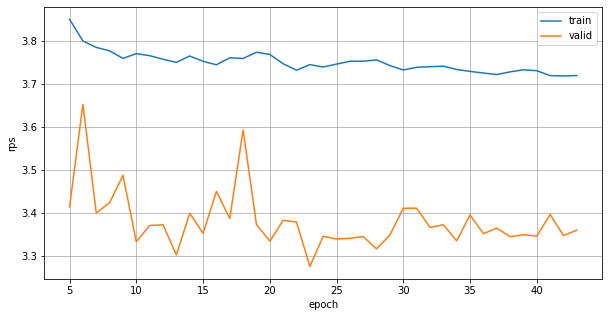

Train model for fold: 2/5


Layer (type:depth-idx)                   Param #
DNN                                      --
├─BatchNorm1d: 1-1                       54
├─Dropout: 1-2                           --
├─Linear: 1-3                            196
├─ModuleList: 1-4                        --
│    └─BatchNorm1d: 2-1                  14
│    └─BatchNorm1d: 2-2                  14
│    └─BatchNorm1d: 2-3                  14
│    └─BatchNorm1d: 2-4                  14
│    └─BatchNorm1d: 2-5                  14
│    └─BatchNorm1d: 2-6                  14
│    └─BatchNorm1d: 2-7                  14
│    └─BatchNorm1d: 2-8                  14
│    └─BatchNorm1d: 2-9                  14
│    └─BatchNorm1d: 2-10                 14
│    └─BatchNorm1d: 2-11                 14
│    └─BatchNorm1d: 2-12                 14
├─ModuleList: 1-5                        --
│    └─Dropout: 2-13                     --
│    └─Dropout: 2-14                     --
│    └─Dropout: 2-15                     --
│    └─Dropout: 2-16      

 32%|███▏      | 32/100 [04:14<09:00,  7.95s/it, a_train_loss=3.703601, b_valid_loss=3.331467, c_best_loss=3.291098, g_es_counter=19]


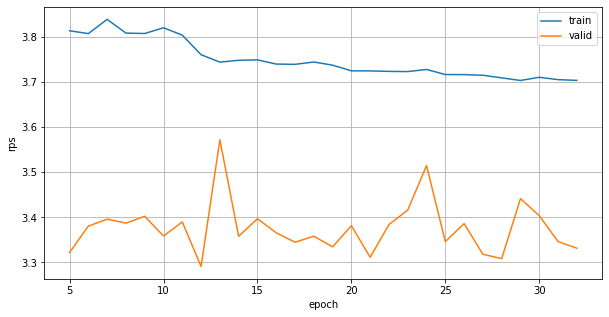

Train model for fold: 3/5


Layer (type:depth-idx)                   Param #
DNN                                      --
├─BatchNorm1d: 1-1                       54
├─Dropout: 1-2                           --
├─Linear: 1-3                            196
├─ModuleList: 1-4                        --
│    └─BatchNorm1d: 2-1                  14
│    └─BatchNorm1d: 2-2                  14
│    └─BatchNorm1d: 2-3                  14
│    └─BatchNorm1d: 2-4                  14
│    └─BatchNorm1d: 2-5                  14
│    └─BatchNorm1d: 2-6                  14
│    └─BatchNorm1d: 2-7                  14
│    └─BatchNorm1d: 2-8                  14
│    └─BatchNorm1d: 2-9                  14
│    └─BatchNorm1d: 2-10                 14
│    └─BatchNorm1d: 2-11                 14
│    └─BatchNorm1d: 2-12                 14
├─ModuleList: 1-5                        --
│    └─Dropout: 2-13                     --
│    └─Dropout: 2-14                     --
│    └─Dropout: 2-15                     --
│    └─Dropout: 2-16      

 42%|████▏     | 42/100 [05:37<07:45,  8.03s/it, a_train_loss=3.798576, b_valid_loss=3.860560, c_best_loss=3.410099, g_es_counter=19]


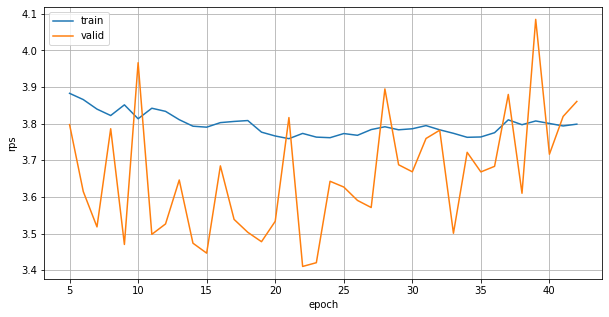

Train model for fold: 4/5


Layer (type:depth-idx)                   Param #
DNN                                      --
├─BatchNorm1d: 1-1                       54
├─Dropout: 1-2                           --
├─Linear: 1-3                            196
├─ModuleList: 1-4                        --
│    └─BatchNorm1d: 2-1                  14
│    └─BatchNorm1d: 2-2                  14
│    └─BatchNorm1d: 2-3                  14
│    └─BatchNorm1d: 2-4                  14
│    └─BatchNorm1d: 2-5                  14
│    └─BatchNorm1d: 2-6                  14
│    └─BatchNorm1d: 2-7                  14
│    └─BatchNorm1d: 2-8                  14
│    └─BatchNorm1d: 2-9                  14
│    └─BatchNorm1d: 2-10                 14
│    └─BatchNorm1d: 2-11                 14
│    └─BatchNorm1d: 2-12                 14
├─ModuleList: 1-5                        --
│    └─Dropout: 2-13                     --
│    └─Dropout: 2-14                     --
│    └─Dropout: 2-15                     --
│    └─Dropout: 2-16      

 93%|█████████▎| 93/100 [13:39<01:01,  8.81s/it, a_train_loss=3.707681, b_valid_loss=3.401434, c_best_loss=3.324811, g_es_counter=19]


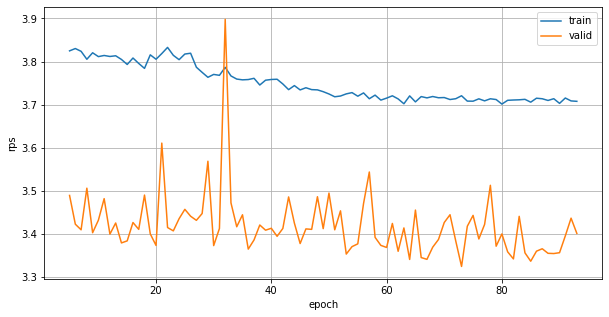

Train model for fold: 5/5


Layer (type:depth-idx)                   Param #
DNN                                      --
├─BatchNorm1d: 1-1                       54
├─Dropout: 1-2                           --
├─Linear: 1-3                            196
├─ModuleList: 1-4                        --
│    └─BatchNorm1d: 2-1                  14
│    └─BatchNorm1d: 2-2                  14
│    └─BatchNorm1d: 2-3                  14
│    └─BatchNorm1d: 2-4                  14
│    └─BatchNorm1d: 2-5                  14
│    └─BatchNorm1d: 2-6                  14
│    └─BatchNorm1d: 2-7                  14
│    └─BatchNorm1d: 2-8                  14
│    └─BatchNorm1d: 2-9                  14
│    └─BatchNorm1d: 2-10                 14
│    └─BatchNorm1d: 2-11                 14
│    └─BatchNorm1d: 2-12                 14
├─ModuleList: 1-5                        --
│    └─Dropout: 2-13                     --
│    └─Dropout: 2-14                     --
│    └─Dropout: 2-15                     --
│    └─Dropout: 2-16      

 30%|███       | 30/100 [04:55<11:30,  9.86s/it, a_train_loss=3.911044, b_valid_loss=3.540234, c_best_loss=3.439186, g_es_counter=19]


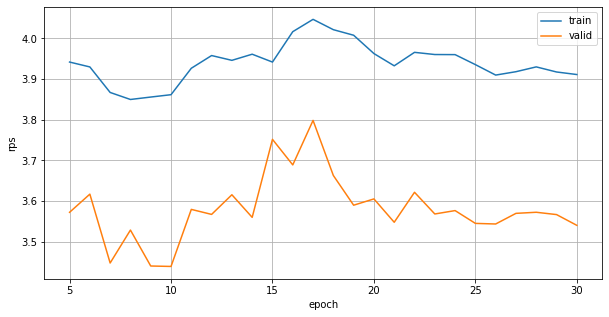

In [45]:
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
strat_cols = ["item_domain_id", "no_stockout", "inventory_days"]
mskf_split = mskf.split(dataset, dataset[strat_cols])

models_by_fold = list()
oof_preds = list()

for fold,(train_idx,valid_idx) in enumerate(mskf_split):
    print(f"Train model for fold: {fold+1}/5")
    
    x_train = dataset.loc[train_idx,input_cols]
    y_train = targets.iloc[train_idx,1:]
    x_valid = dataset.loc[valid_idx,input_cols]
    y_valid = targets.iloc[valid_idx,1:]
    
    train_dset = TensorDataset(
        torch.tensor(x_train.values, dtype=torch.float),
        torch.tensor(y_train.values, dtype=torch.float),
    )
    valid_dset = TensorDataset(
        torch.tensor(x_valid.values, dtype=torch.float),
        torch.tensor(y_valid.values, dtype=torch.float),
    )
    train_dataloader = DataLoader(
        train_dset, 
        batch_size=1024, 
        shuffle=True, 
        num_workers=2, 
        pin_memory=True
    )
    valid_dataloader = DataLoader(
        valid_dset, 
        batch_size=len(valid_dset), 
        shuffle=False, 
        num_workers=2, 
        pin_memory=True
    )
    model = DNN(
        input_dim=len(input_cols),
        output_dim=30, 
        nn_depth=len(input_cols)//2, 
        nn_width=7, 
        dropout=0.2, 
        momentum=0.1,
    )
    display(torchinfo.summary(model))
    
    model,monitor = pax.iterative_train(
        model, 
        train_dataloader, 
        valid_dataloader, 
        max_epochs=100, 
        patience=20,
        clip_value=0.05,
    )
    model.load_state_dict(monitor.best_model_state)
    models_by_fold.append(model)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(5, len(monitor.train_loss)), monitor.train_loss[5:], label="train")
    plt.plot(np.arange(5, len(monitor.valid_loss)), monitor.valid_loss[5:], label="valid")
    plt.xlabel("epoch")
    plt.ylabel("rps")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    
    preds_proba = pax.iterative_predict(model, valid_dataloader).detach().cpu().numpy()
    preds_proba = pd.DataFrame(preds_proba, index=dataset.loc[valid_idx,"sku"].values)
    oof_preds.append(preds_proba)

In [46]:
oof_preds = pd.concat(oof_preds)
oof_preds = oof_preds.loc[targets.sku.values,:].copy()

In [47]:
# softmax output
assert (targets.sku.values == oof_preds.index.values).all()
print("RPS:", compute_rps(np.cumsum(oof_preds.values, axis=1), targets.iloc[:,1:].values))

RPS: 3.348051972565284


***
## inspecting the predictions

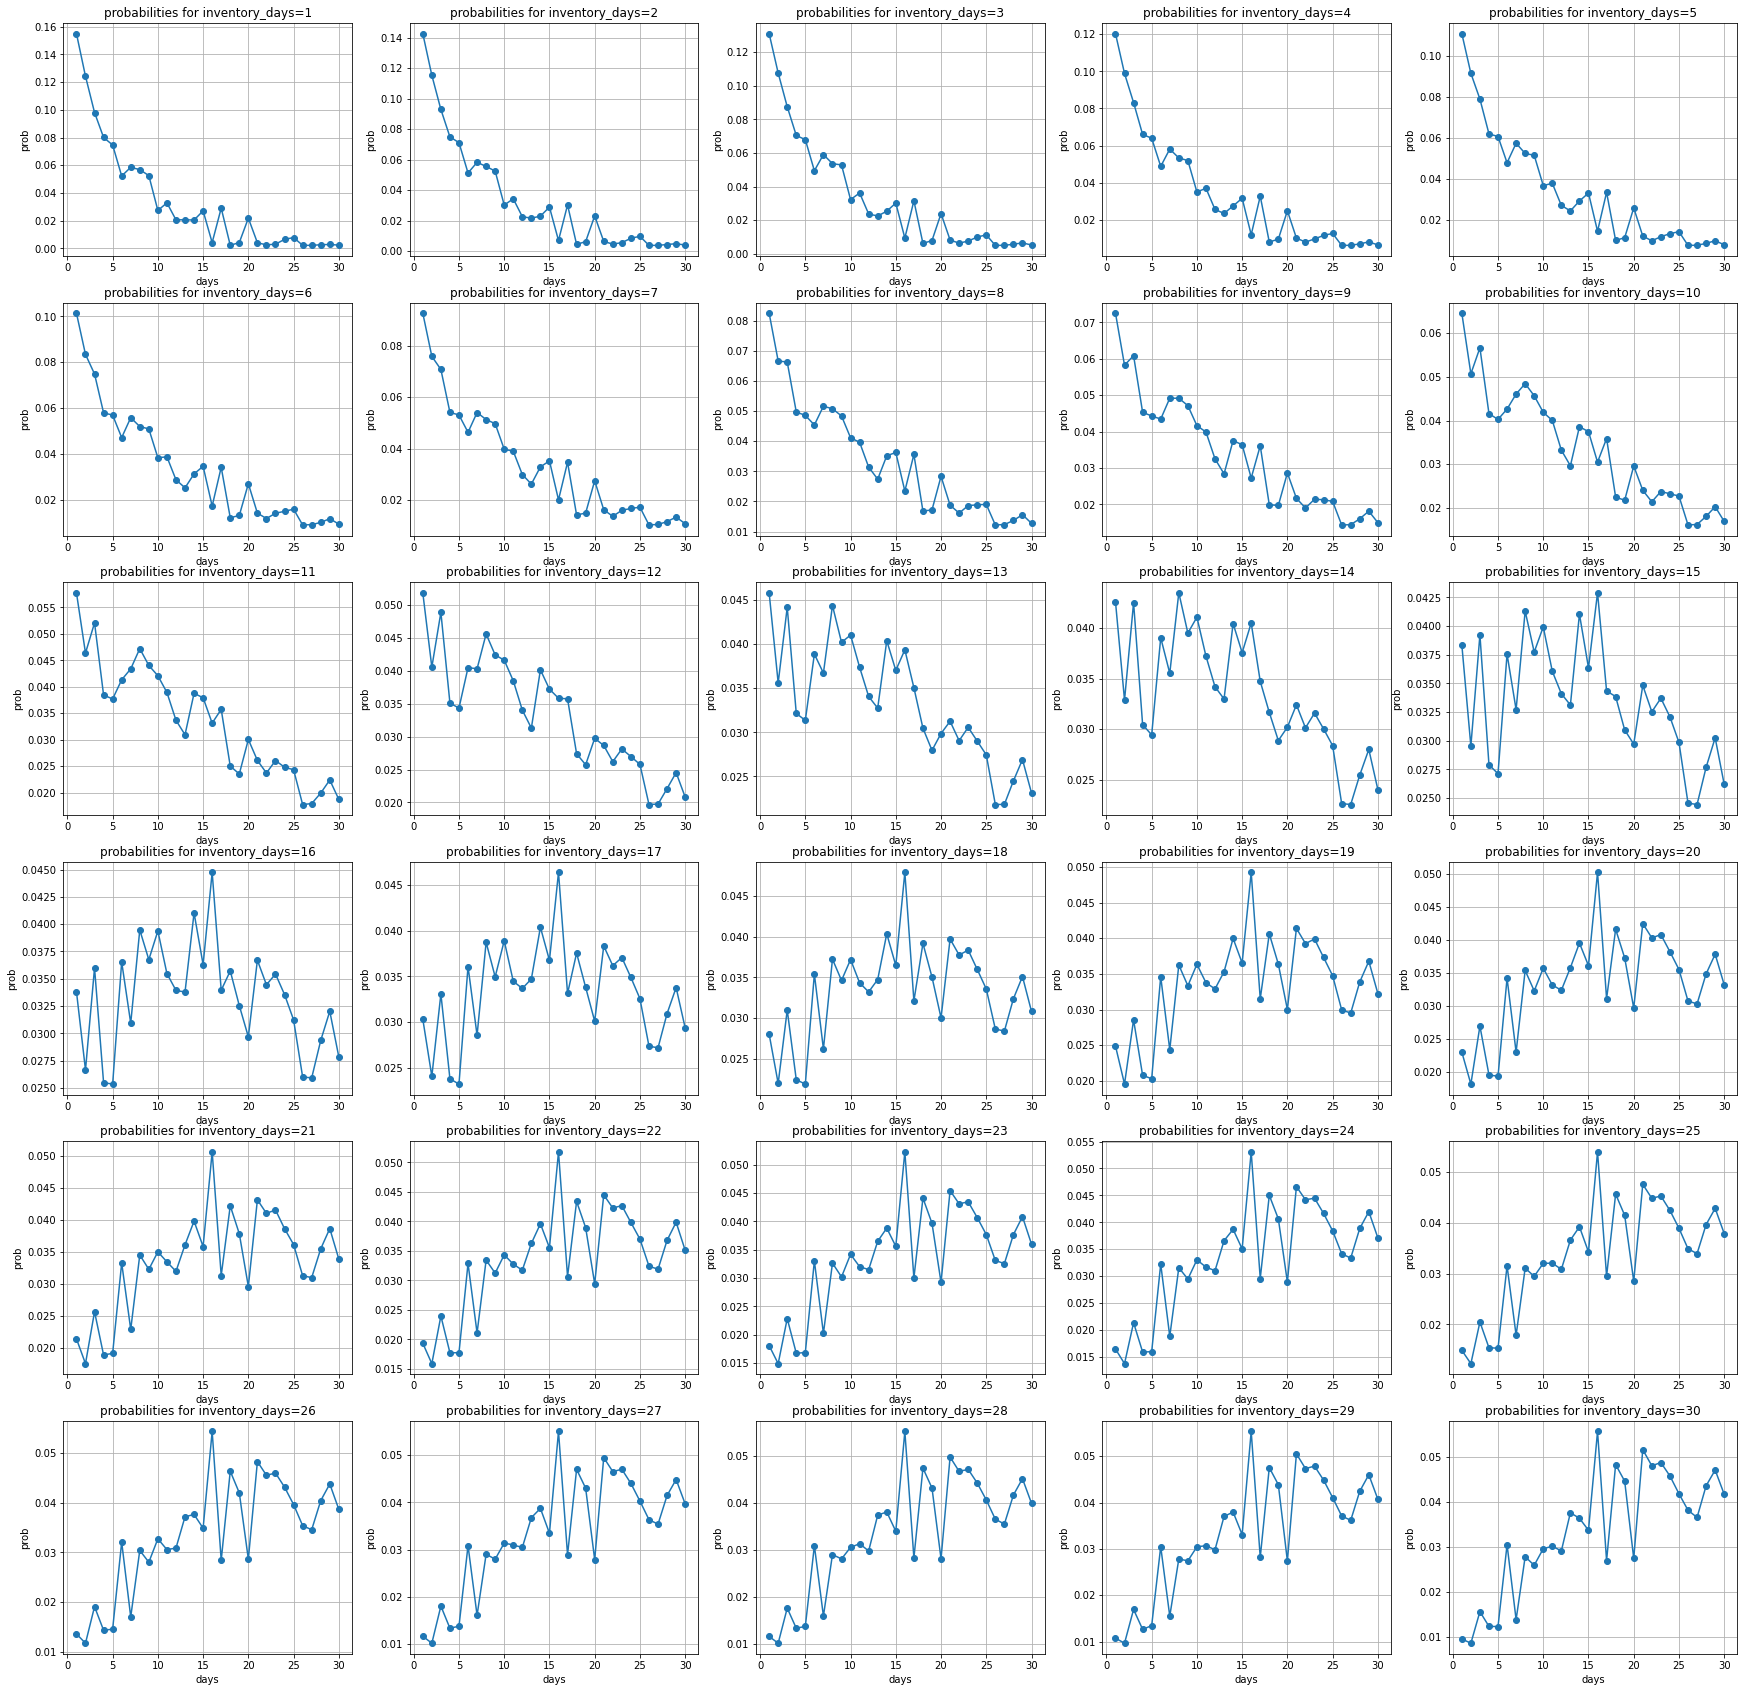

In [48]:
plt.figure(figsize=(30,30))
for idays in range(1,31):
    df = valid.query("inventory_days == @idays")
    averaged = oof_preds.loc[df.sku.values].mean(axis=0)
    plt.subplot(6,5,idays)
    plt.plot(averaged.index+1, averaged.values, "o-")
    plt.title(f"probabilities for inventory_days={idays}")
    plt.grid()
    plt.xlabel("days")
    plt.ylabel("prob")
plt.show()

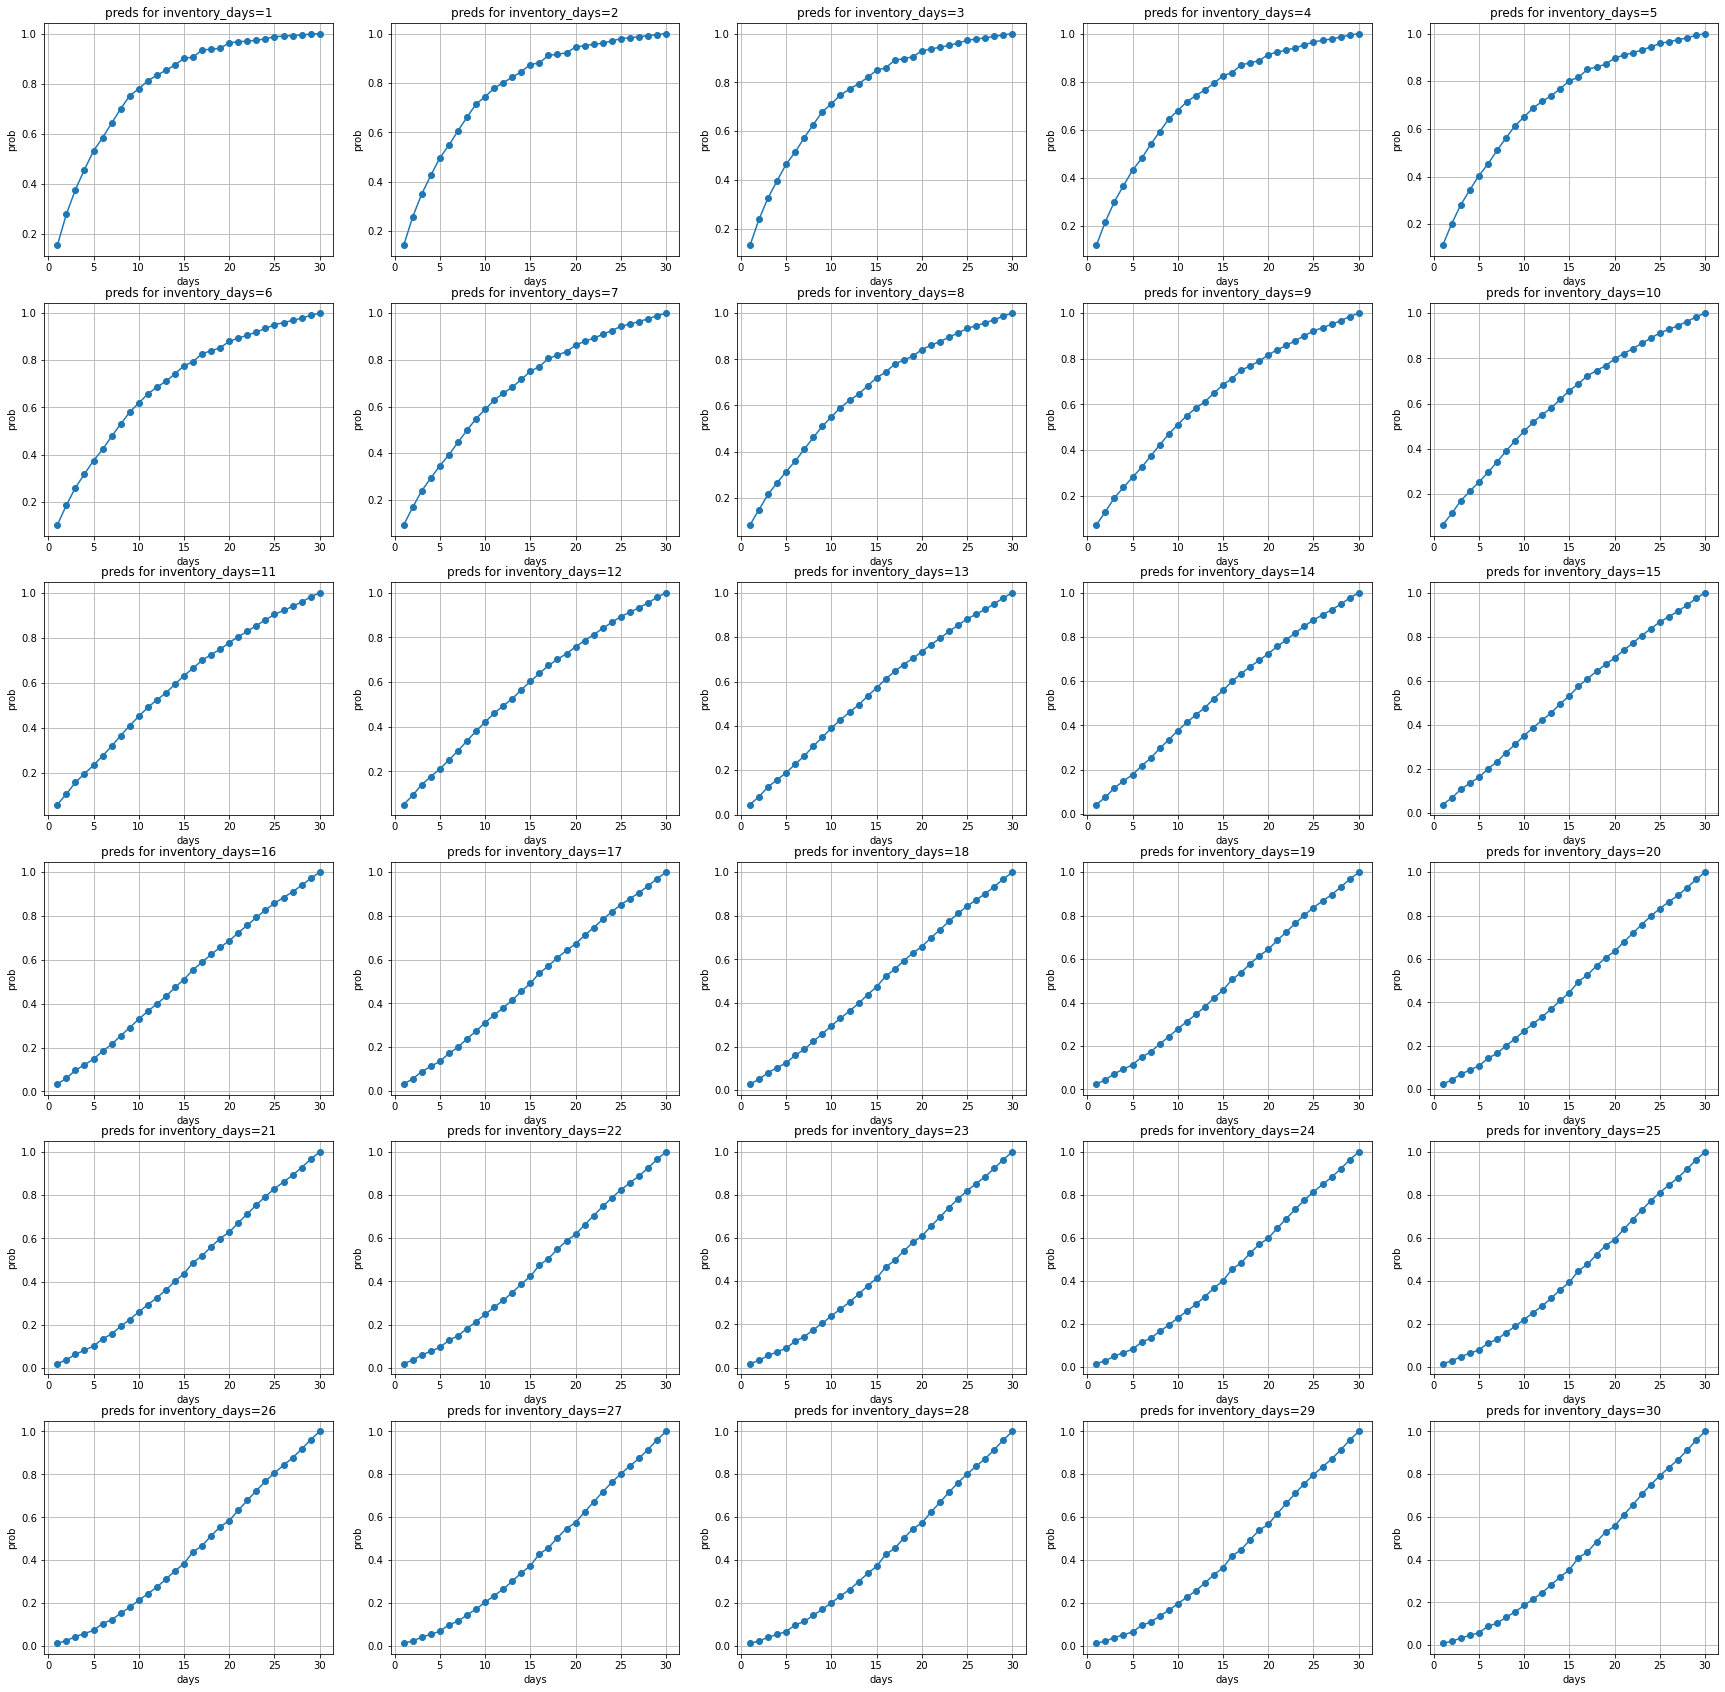

In [49]:
plt.figure(figsize=(30,30))
for idays in range(1,31):
    df = valid.query("inventory_days == @idays")
    averaged = np.cumsum(oof_preds.loc[df.sku.values], axis=1).mean(axis=0)
    plt.subplot(6,5,idays)
    plt.plot(averaged.index+1, averaged.values, "o-")
    plt.title(f"preds for inventory_days={idays}")
    plt.grid()
    plt.xlabel("days")
    plt.ylabel("prob")
plt.show()


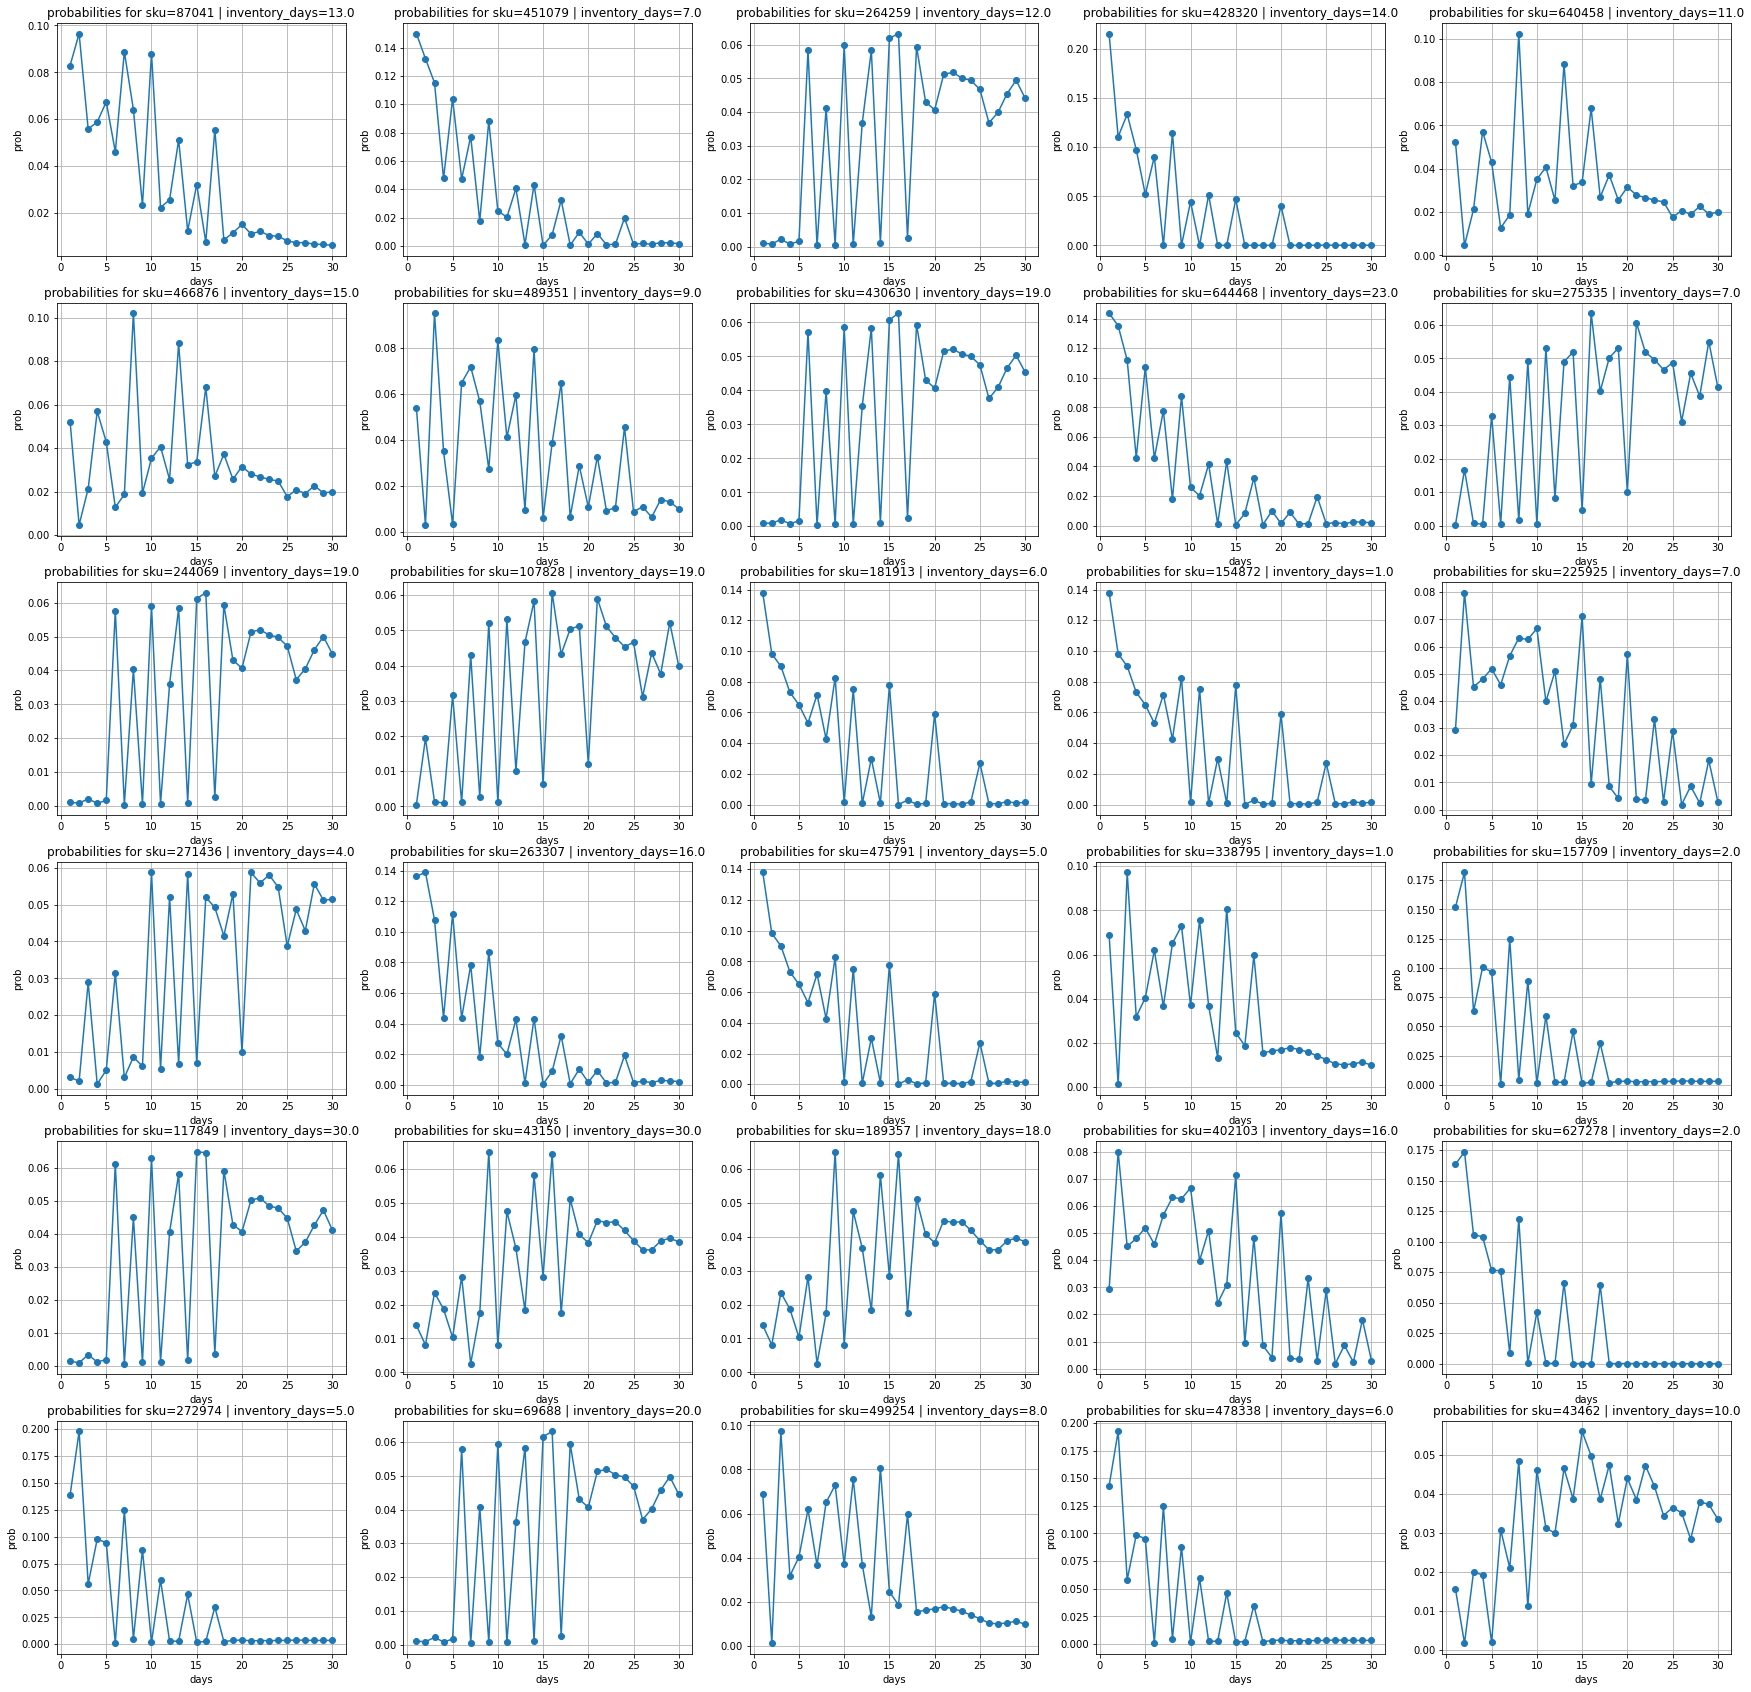

In [50]:
oof_sample = oof_preds.sample(30)

plt.figure(figsize=(30,30))
for i,sku in enumerate(oof_sample.index):
    idays = valid.query("sku == @sku").inventory_days.values[0]
    plt.subplot(6,5,i+1)
    plt.plot(oof_sample.loc[sku].index+1, oof_sample.loc[sku].values, "o-")
    plt.title(f"probabilities for sku={sku} | inventory_days={idays}")
    plt.grid()
    plt.xlabel("days")
    plt.ylabel("prob")
plt.show()

***
## inference - data preparation

In [51]:
predictions = pd.read_csv(f"{results_path}/preds_m1_lgbm_sub14.csv")
pred_skus = predictions.sku.unique()
len(pred_skus)

526189

In [52]:
fit_stats = pd.read_csv(f"{results_path}/train_errors_lgbm-m1-stg2.csv")
fit_stats.drop(["q_mean","site_id"], axis=1, inplace=True)

for col in fit_stats.columns:
    fit_stats[col] = fit_stats[col].fillna(fit_stats[col].median())
    
len(fit_stats)

526189

In [53]:
dataset = (
    pd.read_parquet(f"{input_path}/train.parquet")
    .query("sku in @pred_skus")
    .sort_values(["sku","date"])
    .reset_index(drop=True)
)
dataset.sku.nunique()

526189

In [54]:
raw = (
    pd.read_parquet(
        f"{input_path}/train_data.parquet", 
        columns=["sku", "date", "sold_quantity", "minutes_active"]
    )
    .query("sku in @pred_skus")
    .sort_values(["sku","date"])
    .reset_index(drop=True)
)
metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
raw = pd.merge(raw, metadata, how="inner", on="sku")
raw.sku.nunique()

526189

In [55]:
test = (
    pd.read_csv(f"{input_path}/test_data.csv")
    .query("sku in @pred_skus")
    .reset_index(drop=True)
)
test.sku.nunique()

526189

In [57]:
feat = Featurador(raw)
feat.fit(left_limit="2021-02-01", right_limit="2021-03-31")
dataset = feat.transform(dataset)

In [58]:
dataset["was_active"] = dataset.eval("minutes_active > 0")
dataset["had_sales"] = dataset.eval("sold_quantity > 0")

dataset["tr_points"] = dataset.groupby("sku")["date"].transform("count")
dataset["completeness"] = dataset.tr_points / (dataset.date.nunique())

dataset["minutes_rate1"] = dataset.groupby("sku")["minutes_active"].transform("sum") / (dataset.tr_points*1440)
dataset["minutes_rate2"] = dataset.groupby("sku")["minutes_active"].transform("sum") / (dataset.date.nunique()*1440)

dataset["activity_rate1"] = dataset.groupby("sku")["was_active"].transform("sum") / (dataset.tr_points)
dataset["activity_rate2"] = dataset.groupby("sku")["was_active"].transform("sum") / (dataset.date.nunique())

dataset["sales_rate1"] = dataset.groupby("sku")["had_sales"].transform("sum") / (dataset.tr_points)
dataset["sales_rate2"] = dataset.groupby("sku")["had_sales"].transform("sum") / (dataset.date.nunique())

dataset["q_mean_raw"] = dataset.groupby("sku")["sold_quantity"].transform("mean")
dataset["q_std_raw"] = dataset.groupby("sku")["sold_quantity"].transform("std")

In [59]:
# imputation of nan values
idx = dataset[dataset["q_mean"].isna()].index
dataset.loc[idx, "q_mean"] = dataset.q_mean.median()

idx = dataset[dataset["q_std"].isna()].index
dataset.loc[idx, "q_std"] = dataset.q_std.median()

idx = dataset[dataset["q_mean_raw"].isna()].index
dataset.loc[idx, "q_mean_raw"] = dataset.q_mean_raw.median()

idx = dataset[dataset["q_std_raw"].isna()].index
dataset.loc[idx, "q_std_raw"] = dataset.q_std_raw.median()

In [60]:
dataset["std_days"] = dataset.eval("q_std / q_mean")
idx = dataset[dataset["std_days"].isna()].index
dataset.loc[idx, "std_days"] = dataset.std_days.median()
print(len(idx))

dataset["std_days_raw"] = dataset.eval("q_std_raw / q_mean_raw")
idx = dataset[dataset["std_days_raw"].isna()].index
dataset.loc[idx, "std_days_raw"] = dataset.std_days_raw.median()
print(len(idx))

0
0


In [61]:
dataset = dataset.drop_duplicates(subset=["sku"], ignore_index=True)
display(dataset)
gc.collect()

,date,sku,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,available,item_domain_id,item_id,site_id,product_id,product_family_id,q_mean,q_std,was_active,had_sales,tr_points,completeness,minutes_rate1,minutes_rate2,activity_rate1,activity_rate2,sales_rate1,sales_rate2,q_mean_raw,q_std_raw,std_days,std_days_raw
0,2021-02-01,0,0,172.789993,REA,classic,cross_docking,free_shipping,0.000000,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732,0.215558,0.482631,False,False,59,1.000000,0.864922,0.864922,0.898305,0.898305,0.101695,0.101695,0.186441,0.655864,2.238988,3.517817
1,2021-02-01,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.000000,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None,0.763534,0.945334,False,False,59,1.000000,0.465593,0.465593,0.474576,0.474576,0.220339,0.220339,0.372881,0.785610,1.238103,2.106863
2,2021-03-09,2,0,299.000000,MEX,premium,drop_off,free_shipping,517.583313,1,MLM-NECKLACES,69847,MLM,None,None,0.044724,0.042724,True,False,23,0.389831,0.972149,0.378973,1.000000,0.389831,0.043478,0.016949,0.043478,0.208514,0.955276,4.795832
3,2021-02-01,3,0,399.000000,MEX,premium,fulfillment,free_shipping,1440.000000,1,MLM-RINGS,298603,MLM,None,None,0.316329,0.216265,True,False,59,1.000000,0.427778,0.427778,0.440678,0.440678,0.135593,0.135593,0.135593,0.345295,0.683671,2.546549
4,2021-02-01,5,0,558.690002,MEX,premium,fulfillment,free_shipping,0.000000,1,MLM-RADIO_FREQUENCY_MACHINES,124265,MLM,None,None,0.453772,0.429372,False,False,59,1.000000,0.560275,0.560275,0.576271,0.576271,0.203390,0.203390,0.254237,0.544351,0.946228,2.141114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526184,2021-02-01,660909,1,245.000000,ARG,classic,fulfillment,paid_shipping,1440.000000,1,MLA-PENCILS,430327,MLA,None,None,0.372881,0.471129,True,True,59,1.000000,1.000000,1.000000,1.000000,1.000000,0.305085,0.305085,0.372881,0.692280,1.263482,1.856570
526185,2021-02-01,660911,0,14.310000,REA,classic,fulfillment,paid_shipping,1440.000000,1,MLB-CELLPHONE_PARTS,320792,MLB,None,None,0.385074,0.487071,True,False,59,1.000000,0.812653,0.812653,0.864407,0.864407,0.237288,0.237288,0.322034,0.654972,1.264875,2.033862
526186,2021-02-01,660912,0,99.000000,MEX,classic,fulfillment,paid_shipping,1440.000000,1,MLM-AUTOMOTIVE_EMBLEMS,90441,MLM,None,None,0.254217,0.534028,True,False,59,1.000000,0.885747,0.885747,0.898305,0.898305,0.152542,0.152542,0.237288,0.703170,2.100681,2.963358
526187,2021-02-01,660913,0,149.899994,REA,premium,drop_off,free_shipping,1440.000000,1,MLB-SOFA_AND_FUTON_COVERS,202580,MLB,None,None,0.185304,0.387188,True,False,59,1.000000,0.861015,0.861015,0.881356,0.881356,0.118644,0.118644,0.169492,0.591682,2.089471,3.490924


274433

In [65]:
# inventory days predictions
predictor = IDP()
predictor.fit(predictions)

preds1 = list()
preds2 = list()
for i,row in tqdm(test.iterrows()):
    idp,idp_clip = predictor.predict(int(row.sku), int(row.target_stock))
    preds1.append(idp)
    preds2.append(idp_clip)
    
id_preds = pd.DataFrame({
    "sku":test.sku.values, 
    "idp":preds1, 
    "idp_clip":preds2}
)
id_preds["no_stockout"] = id_preds.eval("idp > 30").astype(int)
id_preds = pd.merge(id_preds, test, how="inner", on="sku")
id_preds

100%|██████████| 526189/526189 [01:11<00:00, 7343.96it/s]
526189it [01:14, 7035.40it/s]


,sku,idp,idp_clip,no_stockout,target_stock
0,464801,7.125894,7.125894,0,3
1,645793,10.717556,10.717556,0,4
2,99516,3.445975,3.445975,0,8
3,538100,9.702686,9.702686,0,8
4,557191,10.961609,10.961609,0,10
...,...,...,...,...,...
526184,513612,5.308590,5.308590,0,32
526185,172296,3.191046,3.191046,0,12
526186,127177,1.861777,1.861777,0,2
526187,347634,9.638502,9.638502,0,17


In [67]:
dataset = (
    dataset
    .merge(id_preds, how="inner", on="sku")
    .merge(fit_stats, how="inner", on="sku")
)
dataset["idp_naive1"] = dataset.eval("target_stock / q_mean")
dataset["idp_naive2"] = dataset.eval("target_stock / q_mean_raw")
dataset.isna().sum(axis=0)

date                           0
sku                            0
sold_quantity                  0
current_price                  0
currency                       0
listing_type                   0
shipping_logistic_type         0
shipping_payment               0
minutes_active                 0
available                      0
item_domain_id                 1
item_id                        0
site_id                        0
product_id                505256
product_family_id         463734
q_mean                         0
q_std                          0
was_active                     0
had_sales                      0
tr_points                      0
completeness                   0
minutes_rate1                  0
minutes_rate2                  0
activity_rate1                 0
activity_rate2                 0
sales_rate1                    0
sales_rate2                    0
q_mean_raw                     0
q_std_raw                      0
std_days                       0
std_days_r

In [68]:
transformed = encoder.transform(dataset[categ_cols])
dataset[transformed.columns] = transformed.values

In [73]:
assert dataset[input_cols].isna().sum(axis=0).sum() == 0

***
## inference

In [82]:
preds_by_fold = list()

for i,model in enumerate(models_by_fold):
    print(f"Making predictions with model: {i+1}/5")
    
    x_test = dataset.loc[:,input_cols]
    x_test = torch.tensor(x_test.values, dtype=torch.float)
    preds_proba = model(x_test).detach().cpu().numpy()
    preds_by_fold.append(preds_proba)

Making predictions with model: 1/5
Making predictions with model: 2/5
Making predictions with model: 3/5
Making predictions with model: 4/5
Making predictions with model: 5/5


In [102]:
preds_proba = np.mean(preds_by_fold, axis=0)
preds_proba = preds_proba / preds_proba.sum(axis=1).reshape(-1,1)
preds_proba = pd.DataFrame(preds_proba, index=dataset.sku.values)

In [106]:
unpredictable = pd.read_csv(f"{input_path}/unpredictable.csv")
unpreds_proba = np.ones((len(unpredictable),30)) / 30
unpreds_proba = pd.DataFrame(unpreds_proba, index=unpredictable.sku.values)

preds_proba_mrg = pd.concat([preds_proba, unpreds_proba])
preds_proba_mrg

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.155854,0.133627,0.096865,0.081042,0.081062,0.051387,0.063861,0.055194,0.052729,0.030842,0.032044,0.020303,0.020187,0.018393,0.026135,0.002238,0.028262,0.000772,0.003085,0.021380,0.002769,0.001373,0.001259,0.005228,0.006590,0.001461,0.001299,0.001727,0.001533,0.001498
1,0.003542,0.004358,0.010492,0.009886,0.009970,0.027721,0.010519,0.023601,0.022444,0.024747,0.029418,0.025953,0.038988,0.032244,0.031067,0.056740,0.023056,0.050361,0.049209,0.024195,0.057590,0.051163,0.053701,0.050678,0.045807,0.042655,0.039889,0.049143,0.053638,0.047224
2,0.003884,0.004558,0.010797,0.009597,0.009996,0.028771,0.010577,0.024250,0.022946,0.025863,0.029238,0.026973,0.038619,0.033484,0.031907,0.057646,0.024335,0.050617,0.048425,0.025265,0.056236,0.051309,0.052884,0.049603,0.045081,0.041564,0.039614,0.047849,0.052125,0.045988
3,0.018006,0.008352,0.027554,0.016588,0.016143,0.032813,0.022995,0.041246,0.034366,0.040985,0.035231,0.038445,0.038817,0.049543,0.032649,0.058378,0.034396,0.043724,0.037458,0.030224,0.041936,0.039727,0.037333,0.036995,0.031941,0.028786,0.029255,0.031926,0.033905,0.030284
5,0.003928,0.005211,0.010854,0.009732,0.009836,0.028048,0.010263,0.024170,0.023864,0.025434,0.029556,0.026652,0.038303,0.034851,0.031951,0.057236,0.024919,0.051108,0.048047,0.025728,0.056074,0.051163,0.052509,0.049534,0.044738,0.041843,0.039263,0.047854,0.051493,0.045840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393191,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
262125,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
393209,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
131068,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


***
## generate submission

In [107]:
test = pd.read_csv(f"{input_path}/test_data.csv")
preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()

In [108]:
assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-16)
assert preds_proba_mrg.max(axis=1).max() < 1

In [110]:
(preds_proba_mrg
 .round(4)
 .to_csv(f"{subs_path}/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
)

***